# Project 1 Step 6 Match Return And Plot Figure 1
In this notebook, we will do the following:
- Load in the negative words proportions calculated for each document in the last step
- Use its ticker and filing date to find the 4-day buy-and-hold excess stock returns in the return csv file we prepared in step 4
- Split all negative word proportions into 5 portfolios according to the level of negative word proportions
- Replicate figure 1 using current data we have

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
import pandas as pd
import numpy as np
import os
import warnings

warnings.filterwarnings("ignore")

from datetime import date
from tqdm import tqdm
from joblib import Parallel, delayed
import multiprocessing

from bs4 import BeautifulSoup
import re
from pathlib import Path
import json

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer  # for bag-of-words method

import matplotlib.pyplot as plt

In [3]:
data_path = "/content/drive/MyDrive/Mini 5/Natural Language Processing/Project 1/data/"
data_path_10q = "/content/drive/MyDrive/Mini 5/Natural Language Processing/Project 1/data/10Q/"
data_path_10k = "/content/drive/MyDrive/Mini 5/Natural Language Processing/Project 1/data/10K/"

cik_lookup_filename = "/content/drive/MyDrive/Mini 5/Natural Language Processing/Project 1/CIK_lookup_results_cleaned.csv"
sp500_constituents_path = "/content/drive/MyDrive/Mini 5/Natural Language Processing/Project 1/sp500_constituents.csv"
sp500_id_path = "/content/drive/MyDrive/Mini 5/Natural Language Processing/Project 1/sp500_w_addl_id.csv"

index_return_path = "/content/drive/MyDrive/Mini 5/Natural Language Processing/Project 1/Index_Returns.csv"
stock_return_path = "/content/drive/MyDrive/Mini 5/Natural Language Processing/Project 1/Stock_Prices.csv"
buyhold_excess_return_path = "/content/drive/MyDrive/Mini 5/Natural Language Processing/Project 1/data/Stock_Excess_BuyHoldReturn.csv"

word_list_path = "/content/drive/MyDrive/Mini 5/Natural Language Processing/Project 1/data/WordLists"
H4N_path = "/content/drive/MyDrive/Mini 5/Natural Language Processing/Project 1/Dictionary/Harvard IV_Negative Word List_Inf.txt"
FinNeg_path = "/content/drive/MyDrive/Mini 5/Natural Language Processing/Project 1/Dictionary/Loughran-McDonald_MasterDictionary_1993-2021.csv"
neg_prop_path = "/content/drive/MyDrive/Mini 5/Natural Language Processing/Project 1/data/NegWordProportions"
results_path = "/content/drive/MyDrive/Mini 5/Natural Language Processing/Project 1/data/Results"

#### Load in 4-day Buy-and-Hold Stock Excess Return Data from Step 4

In [4]:
excess_return = pd.read_csv(buyhold_excess_return_path)
excess_return

,date,TICKER,BuyHoldRet_excess
0,20110103,ORCL,-0.013902
1,20110104,ORCL,-0.015287
2,20110105,ORCL,-0.013835
3,20110106,ORCL,-0.001212
4,20110107,ORCL,-0.018513
...,...,...,...
1860802,20211227,TSLA,-0.005754
1860803,20211228,TSLA,-0.028507
1860804,20211229,TSLA,-0.035978
1860805,20211230,TSLA,-0.043188


#### Load in JSON files from Step 5 with Bag of Words method and Match Excess Returns using Ticker and Filing Date

In [5]:
def neg_proportion_match_return(neg_prop_path, excess_return):
  """
  Read in JSON files with negative proportions. Use ticker and filing date to match corresponding 4-day buy-and-hold excess stock return.
  Make result a dataframe. We will concatenate all this kind of dataframes in the next function.
  """
  # read in JSON negative proportion data in step 5
  json_readobj = open(neg_prop_path, "r")
  neg_prop_dict = json.loads(json_readobj.read())

  # prepare lists to record tickers, filing dates, returns, and negative word proportions
  ticker_list = []
  filing_date_list = []
  excess_return_list = []
  neg_prop_list = []

  success_cnt = 0
  failure_cnt = 0
  problem_tuples = []

  for ticker, ticker_dict in tqdm(neg_prop_dict.items()):
    for filing_date, neg_prop in ticker_dict.items():
      try:
        sub_df = excess_return.loc[excess_return['date']==int(filing_date)].loc[excess_return['TICKER']==ticker]
        ret = sub_df['BuyHoldRet_excess'].iloc[0]
        excess_return_list.append(ret)
        ticker_list.append(ticker)
        filing_date_list.append(filing_date)
        neg_prop_list.append(neg_prop)
        success_cnt += 1
      except:
        failure_cnt += 1
        problem_tuples.append((ticker, filing_date, neg_prop))

  # make a dataframe and return it
  result_dict = {'date': filing_date_list, 'ticker': ticker_list, 'BuyHoldRet_excess': excess_return_list, 'NegProportion': neg_prop_list}
  result_df = pd.DataFrame(result_dict)
  return result_df, problem_tuples, success_cnt, failure_cnt

#### Generate dataframes for both the H4N-Inf and Fin--Neg word lists containing all information, including negative word proportion, 4-day buy-and-hold excess stock return

In [6]:
def concat_all_dataframes(which_dict=True):
  """
  This function will call previous function, obtain all dataframes with both info about negative word proportion and 4-day buy-and-hold 
  excess stock return, and concat them together
  """
  if which_dict == True:
    json_suffix = "harvard"
  else:
    json_suffix = "finneg"
  
  total_success_cnt = 0
  total_failure_cnt = 0

  # generate all dataframes
  df_list = []
  problem_list = []
  for i in range(5):
    neg_10k_prop_path = os.path.join(neg_prop_path, "wordlist10k_{}_negprop_{}.json".format(str(i), json_suffix))
    df_i, problem_i, success_cnt_i, failure_cnt_i = neg_proportion_match_return(neg_10k_prop_path, excess_return)
    df_list.append(df_i)
    problem_list += problem_i
    total_success_cnt += success_cnt_i
    total_failure_cnt += failure_cnt_i
  print("################ 10-K finished, 10-Q starts ################")
  for i in range(1, 7):
    neg_10q_prop_path = os.path.join(neg_prop_path, "wordlist10q_{}_negprop_{}.json".format(str(i), json_suffix))
    df_i, problem_i, success_cnt_i, failure_cnt_i = neg_proportion_match_return(neg_10q_prop_path, excess_return)
    df_list.append(df_i)
    problem_list += problem_i
    total_success_cnt += success_cnt_i
    total_failure_cnt += failure_cnt_i

  # save the problematic files into a json file
  problem_dict = {"success_count": total_success_cnt, "failure_count": total_failure_cnt, "problem_files": problem_list}
  with open(os.path.join(results_path, "match_return_problems_{}.json".format(json_suffix)), "w") as outfile_problem:
    json.dump(problem_dict, outfile_problem)
  
  # concatenate all dataframes from 10-K and 10-Q
  return pd.concat(df_list)

In [7]:
match_return_df_harvard = concat_all_dataframes(which_dict=True)
match_return_df_finneg = concat_all_dataframes(which_dict=False)

100%|██████████| 108/108 [00:26<00:00,  4.05it/s]


################ 10-K finished, 10-Q starts ################


100%|██████████| 108/108 [00:26<00:00,  4.08it/s]


################ 10-K finished, 10-Q starts ################


100%|██████████| 78/78 [02:03<00:00,  1.58s/it]


#### Display the new dataframe with all information for H4N-Inf based word list

In [8]:
match_return_df_harvard

,date,ticker,BuyHoldRet_excess,NegProportion
0,20180205,EBAY,-0.012617,0.102906
1,20190130,EBAY,0.009646,0.099329
2,20200131,EBAY,0.044372,0.097281
3,20210204,EBAY,0.044166,0.094492
4,20200226,DFS,-0.006581,0.091363
...,...,...,...,...
994,20200806,ZTS,-0.004230,0.076985
995,20201105,ZTS,-0.098487,0.081538
996,20210506,ZTS,-0.015032,0.080162
997,20210805,ZTS,-0.037460,0.080283


#### Display the new dataframe with all information for Fin-Neg based word list

In [9]:
match_return_df_finneg

,date,ticker,BuyHoldRet_excess,NegProportion
0,20180205,EBAY,-0.012617,0.040354
1,20190130,EBAY,0.009646,0.039018
2,20200131,EBAY,0.044372,0.041268
3,20210204,EBAY,0.044166,0.038954
4,20200226,DFS,-0.006581,0.032490
...,...,...,...,...
994,20200806,ZTS,-0.004230,0.024960
995,20201105,ZTS,-0.098487,0.025180
996,20210506,ZTS,-0.015032,0.027236
997,20210805,ZTS,-0.037460,0.027713


#### For each of the word lists (H4N-Inf and Fin-Neg), divide them into 5 portfolios based on proportion of negative words

We split samples into 5 portfolios based on the ascending order of negative word proportions. We then use groupby to calculate the median filing period excess returns for these 5 portfolios.

In [16]:
def divide_five_portfolios(input_df):
  """
  This function first sorts input_df according to level of negative word proportion in ascending order. Then we will 
  split all entries into 5 different portfolios. We then use groupby to calculate the median filing period excess returns
  for these 5 portfolios. Finally we can replicate Figure 1 from the paper.
  """
  sorted_input_df = input_df.sort_values(by='NegProportion')
  sorted_input_df = sorted_input_df.reset_index(drop=True, inplace=False)
  df_length = sorted_input_df.shape[0]
  begin_index = [i * (df_length // 5) for i in list(range(5))]
  end_index = begin_index[1:]
  end_index.append(df_length)
  portfolio_assignment_list = np.array(list(range(df_length)))
  label = 1
  for i, j in zip(begin_index, end_index):
    # print(i, j)
    portfolio_assignment_list[i:j] = label
    label += 1
  sorted_input_df['portfolio_label'] = portfolio_assignment_list
  return sorted_input_df

In [17]:
sorted_df_harvard = divide_five_portfolios(match_return_df_harvard)

In [18]:
sorted_df_finneg = divide_five_portfolios(match_return_df_finneg)

In [19]:
sorted_df_harvard

,date,ticker,BuyHoldRet_excess,NegProportion,portfolio_label
0,20161104,DUK,-0.043675,0.001923,1
1,20160804,DUK,-0.014629,0.001923,1
2,20160225,DUK,-0.048714,0.001923,1
3,20170224,DUK,0.002000,0.001923,1
4,20160505,DUK,-0.014355,0.001923,1
...,...,...,...,...,...
9147,20211104,WRB,-0.009210,0.114436,5
9148,20201030,CB,-0.035866,0.114581,5
9149,20210225,CB,-0.002302,0.115357,5
9150,20211028,CB,-0.018410,0.115381,5


In [20]:
sorted_df_finneg

,date,ticker,BuyHoldRet_excess,NegProportion,portfolio_label
0,20150807,DUK,0.022533,0.000000,1
1,20180221,DUK,0.009189,0.000000,1
2,20170224,DUK,0.002000,0.000000,1
3,20160225,DUK,-0.048714,0.000000,1
4,20150507,ETR,-0.029142,0.000000,1
...,...,...,...,...,...
9147,20210428,AMD,-0.075642,0.063824,5
9148,20211102,ANET,0.282377,0.064537,5
9149,20210803,ANET,-0.009494,0.064552,5
9150,20210506,ANET,0.037418,0.064800,5


In [36]:
sorted_df_harvard.to_csv(os.path.join(results_path, "sorted_df_harvard.csv"), index=False)
sorted_df_finneg.to_csv(os.path.join(results_path, "sorted_df_finneg.csv"), index=False)

In [31]:
sorted_df_harvard.groupby("portfolio_label")['BuyHoldRet_excess'].median()

portfolio_label
1    0.000041
2    0.000905
3    0.000496
4   -0.000189
5    0.000019
Name: BuyHoldRet_excess, dtype: float64

In [22]:
sorted_df_finneg.groupby("portfolio_label")['BuyHoldRet_excess'].median()

portfolio_label
1    0.000249
2    0.000468
3    0.000805
4   -0.000745
5    0.000659
Name: BuyHoldRet_excess, dtype: float64

#### Plot the medium filing period excess returns by quintiles according to H4N-Inf and Fin-Neg word lists

In [45]:
def figure_1_plotting(input_df_harvard, input_df_finneg):
  medians_harvard = input_df_harvard.groupby("portfolio_label")['BuyHoldRet_excess'].median().values
  medians_finneg = input_df_finneg.groupby("portfolio_label")['BuyHoldRet_excess'].median().values
  x_ax = [1, 2, 3, 4, 5]

  fig, ax = plt.subplots(1, 1, figsize=(15, 9))
  plt.plot(x_ax, medians_harvard, color='blue', label="H4N-Inf")
  plt.plot(x_ax, medians_finneg, color='orange', label="Fin-Neg")
  plt.legend(loc='upper right')
  plt.xlabel("Quintile (based on proportion of negative words", fontsize=12)
  plt.ylabel("Median Filing Period Excess Return", fontsize=12)
  plt.title("Figure 1", fontsize=14)
  plt.savefig(os.path.join(results_path, "Figure1_BagOfWords.png"))
  # plt.show()

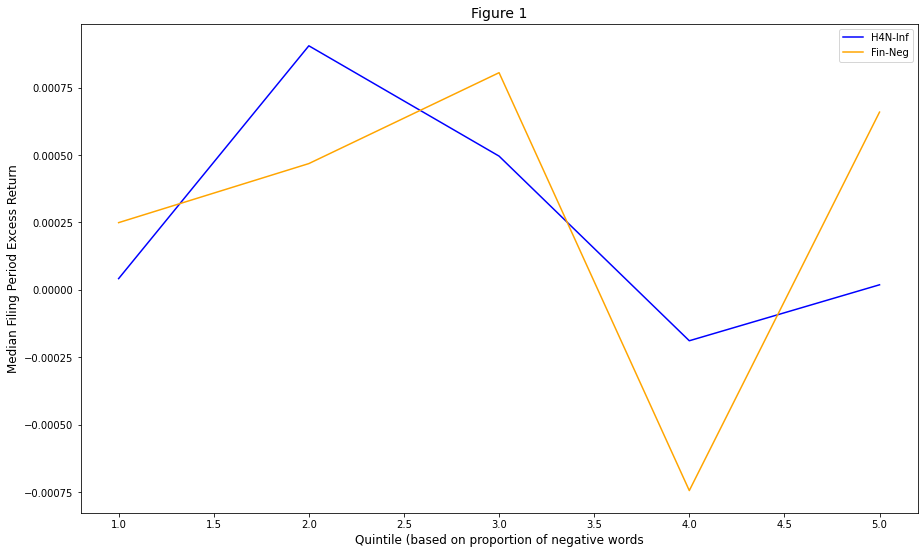

In [46]:
figure_1_plotting(sorted_df_harvard, sorted_df_finneg)